In [1]:
!pip install scikit-optimize
!pip install --upgrade scikit-learn
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 66.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


# loed_data

In [3]:
train=pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')

## inform of datat

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


* **I ran info() and found 9 integer and 9 object (categorical) columns with no missing values, so I didn’t need to fill anything but planned encoding for categoricals to improve model accuracy.**

In [4]:
train.describe()

id            age        balance            day  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      40.926395    1204.067397      16.117209   
std    216506.495284      10.098829    2836.096759       8.250832   
min         0.000000      18.000000   -8019.000000       1.000000   
25%    187499.750000      33.000000       0.000000       9.000000   
50%    374999.500000      39.000000     634.000000      17.000000   
75%    562499.250000      48.000000    1390.000000      21.000000   
max    749999.000000      95.000000   99717.000000      31.000000   

            duration       campaign          pdays       previous  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean      256.229144       2.577008      22.412733       0.298545   
std       272.555662       2.718514      77.319998       1.335926   
min         1.000000       1.000000      -1.000000       0.000000   
25%        91.000000       1.000000      -1.000000       0.000000   
50%       133.000000       2.000000      -1.000000       0.000000   
75%       361.000000       3.000000      -1.000000       0.000000   
max      4918.000000      63.000000     871.000000     200.000000   

                   y  
count  750000.000000  
mean        0.120651  
std         0.325721  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [5]:
test.describe()

id            age        balance            day  \
count  250000.000000  250000.000000  250000.000000  250000.000000   
mean   874999.500000      40.932332    1197.426352      16.116068   
std     72168.927986      10.081613    2741.520699       8.258509   
min    750000.000000      18.000000   -8019.000000       1.000000   
25%    812499.750000      33.000000       0.000000       9.000000   
50%    874999.500000      39.000000     631.000000      17.000000   
75%    937499.250000      48.000000    1389.000000      21.000000   
max    999999.000000      95.000000   98517.000000      31.000000   

            duration       campaign          pdays       previous  
count  250000.000000  250000.000000  250000.000000  250000.000000  
mean      255.342260       2.573548      22.280028       0.303728  
std       271.404326       2.709661      76.915879       1.384574  
min         3.000000       1.000000      -1.000000       0.000000  
25%        91.000000       1.000000      -1.000000       0.000000  
50%       133.000000       2.000000      -1.000000       0.000000  
75%       353.000000       3.000000      -1.000000       0.000000  
max      4918.000000      58.000000     871.000000     150.000000

 *  **I used describe() on the training data to check stats like mean and max for age, balance, duration, etc., and saw outliers (e.g., very high balance) and imbalance (~12% y=1). I used RobustScaler later because it handles outliers better than standard scaling, which is sensitive to them**

# **EDA**

In [5]:
class visual:
    def __init__(self):
        self.numerical_col =[]
        self.categorical_cols = []
    
    def countplot(self,df):
        self.categorical_cols=df.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in self.categorical_cols:
            plt.figure(figsize=(10, 5))
            sns.countplot(x=col, data=df)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            plt.show()
    def grouped_bar_plot(self, df, cat_col, y_col='y', use_proportions=False, figsize=(10, 6)):
        
        # Extract column name if passed as a single-element list
        cat_col = cat_col[0] if isinstance(cat_col, list) else cat_col

        # Validate columns
        if cat_col not in df.columns:
            raise ValueError(f"Column '{cat_col}' not found in DataFrame")
        if y_col not in df.columns:
            raise ValueError(f"Column '{y_col}' not found in DataFrame")

        # Set plot style
        sns.set_style("whitegrid")

        # Create figure
        plt.figure(figsize=figsize)

        # Compute counts or proportions
        if use_proportions:
            plot_data = df.groupby([cat_col, y_col]).size().unstack(fill_value=0)
            plot_data = plot_data.div(plot_data.sum(axis=1), axis=0)
            plot_data = plot_data.stack().reset_index(name='proportion')
            sns.barplot(data=plot_data, x=cat_col, y='proportion', hue=y_col, palette='Set2')
            plt.ylabel('Proportion')
            plt.title(f'Proportion of {y_col} by {cat_col}')
        else:
            sns.countplot(data=df, x=cat_col, hue=y_col, palette='Set2')
            plt.ylabel('Count')
            plt.title(f'Count of {y_col} by {cat_col}')

        # Rotate x-axis labels for readability
        plt.xticks(rotation=45, ha='right')

        # Adjust layout
        plt.tight_layout()
        plt.show()

    def all_categorical_bar_plots(self, df, y_col='y', use_proportions=False, figsize=(10, 6)):
        
        # Validate y_col
        if y_col not in df.columns:
            raise ValueError(f"Column '{y_col}' not found in DataFrame")

        # Identify categorical columns
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        if not cat_cols:
            raise ValueError("No categorical columns found in DataFrame")

        print(f"Generating plots for {len(cat_cols)} categorical columns: {cat_cols}")

        # Generate a plot for each categorical column
        for col in cat_cols:
            self.grouped_bar_plot(df, col, y_col=y_col, use_proportions=use_proportions, figsize=figsize)

        
    def histplot(self,df,y_col='y'):
        self.numerical_col=df.select_dtypes(include=[np.number]).columns.tolist()
        for i in self.numerical_col:
            plt.figure(figsize=(8, 4))
            # Pass the DataFrame to the 'data' parameter and the column names
            # to 'x' and 'hue' parameters.
            sns.histplot(data=df, x=i, kde=True, hue=y_col, element='step', stat='density', common_norm=False)
            plt.title(f'Distribution of {i}')
            plt.xticks(rotation=45)
            plt.show() # Add this to display each plot
    def boxplot(self,df):
        self.numerical_col=df.select_dtypes(include=[np.number]).columns.tolist()
        for col in self.numerical_col:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x='y', y=col, data=df)
            plt.title(f'{col} by Subscription Status')
            plt.show()
    def correlation(self,df):
        self.numerical_col=df.select_dtypes(include=[np.number]).columns.tolist()
        corr = df[self.numerical_col + ['y']].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.show()
    def pairplot(self,df,hue_col='y'):
        sns.pairplot(df, hue=hue_col, diag_kind='kde', markers=["o", "s"], height=2.5)
        plt.show()
    def jointplot(self, df, column1, column2, column3):
        # Extract column names if passed as single-element lists
        col1 = column1[0] if isinstance(column1, list) else column1
        col2 = column2[0] if isinstance(column2, list) else column2
        col3 = column3[0] if isinstance(column3, list) else column3

        # Validate columns
        for col in [col1, col2, col3]:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in DataFrame")

        # Create jointplot
        sns.jointplot(x=df[col1], y=df[col2], hue=df[col3], height=6, marginal_ticks=True)
        plt.show()
    def all_visual(self,df):
        # Correctly calling instance methods with `self` and passing the DataFrame `df`
        self.countplot(df)
        self.all_categorical_bar_plots(df, y_col='y', use_proportions=False)
        self.histplot(df)
        self.boxplot(df)
        self.correlation(df)
        #self.pairplot(df)

In [6]:
V=visual()

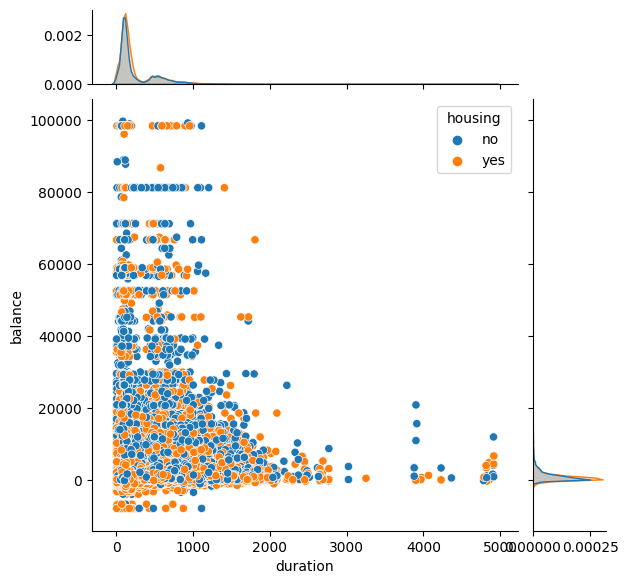

In [12]:
V.jointplot(train,['duration'],['balance'],['housing'])

In [5]:
df_train=train.copy()

In [6]:
df_train

id  age          job   marital  education default  balance  \
0            0   42   technician   married  secondary      no        7   
1            1   38  blue-collar   married  secondary      no      514   
2            2   36  blue-collar   married  secondary      no      602   
3            3   27      student    single  secondary      no       34   
4            4   26   technician   married  secondary      no      889   
...        ...  ...          ...       ...        ...     ...      ...   
749995  749995   29     services    single  secondary      no     1282   
749996  749996   69      retired  divorced   tertiary      no      631   
749997  749997   50  blue-collar   married  secondary      no      217   
749998  749998   32   technician   married  secondary      no     -274   
749999  749999   42   technician   married  secondary      no     1559   

       housing loan   contact  day month  duration  campaign  pdays  previous  \
0           no   no  cellular   25   aug       117         3     -1         0   
1           no   no   unknown   18   jun       185         1     -1         0   
2          yes   no   unknown   14   may       111         2     -1         0   
3          yes   no   unknown   28   may        10         2     -1         0   
4          yes   no  cellular    3   feb       902         1     -1         0   
...        ...  ...       ...  ...   ...       ...       ...    ...       ...   
749995      no  yes   unknown    4   jul      1006         2     -1         0   
749996      no   no  cellular   19   aug        87         1     -1         0   
749997     yes   no  cellular   17   apr       113         1     -1         0   
749998      no   no  cellular   26   aug       108         6     -1         0   
749999      no   no  cellular    4   aug       143         1      1         7   

       poutcome  y  
0       unknown  0  
1       unknown  0  
2       unknown  0  
3       unknown  0  
4       unknown  1  
...         ... ..  
749995  unknown  1  
749996  unknown  0  
749997  unknown  0  
749998  unknown  0  
749999  failure  0  

[750000 rows x 18 columns]

In [7]:
df_train= df_train.drop(['id'],axis=1)

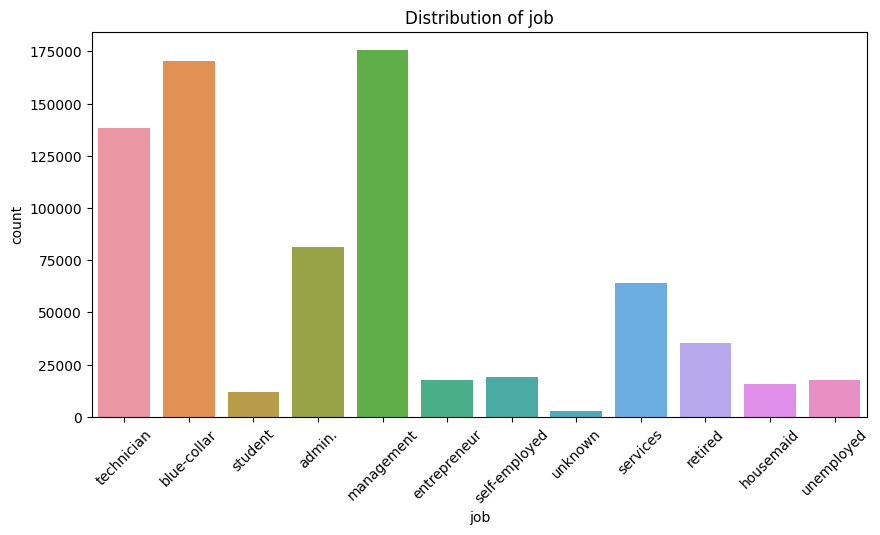

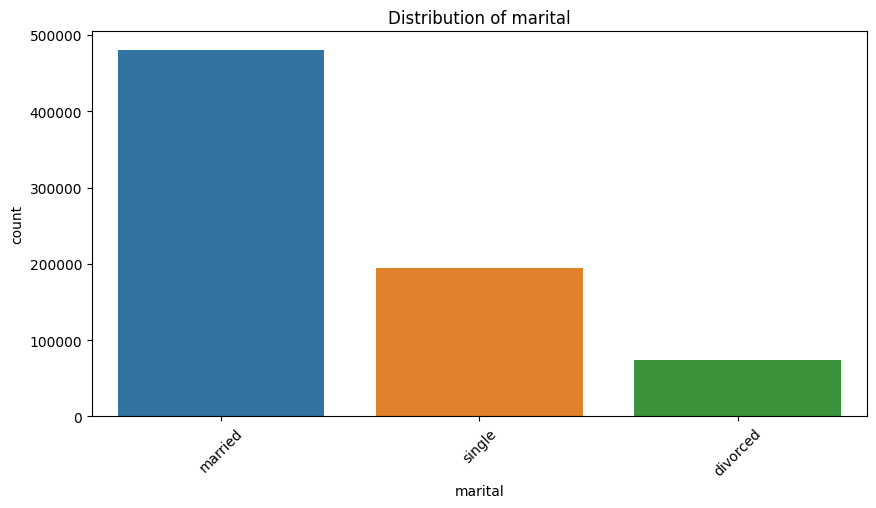

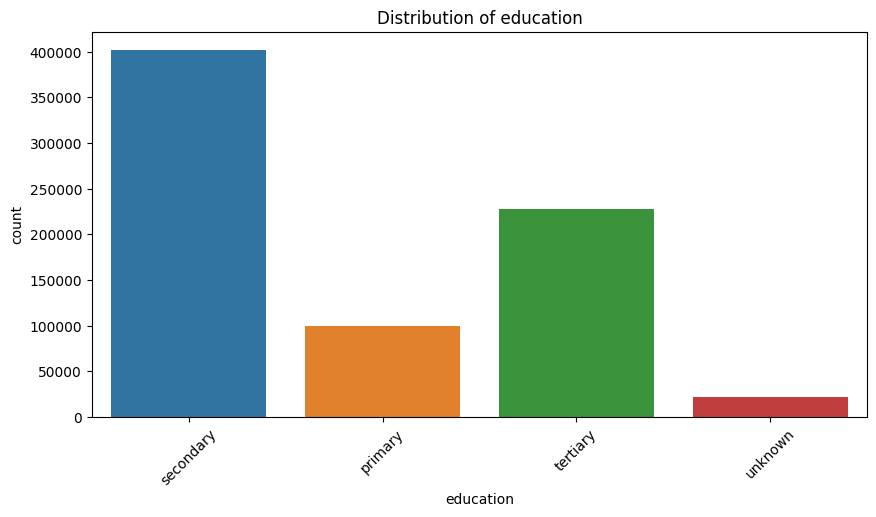

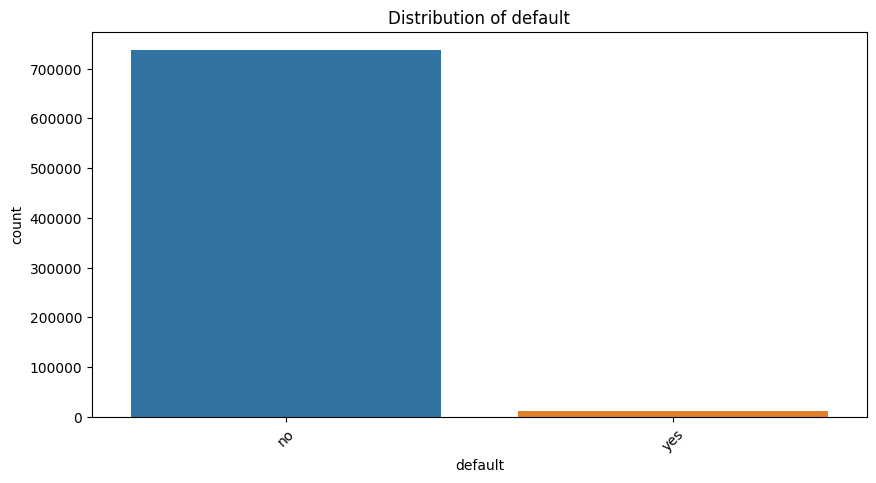

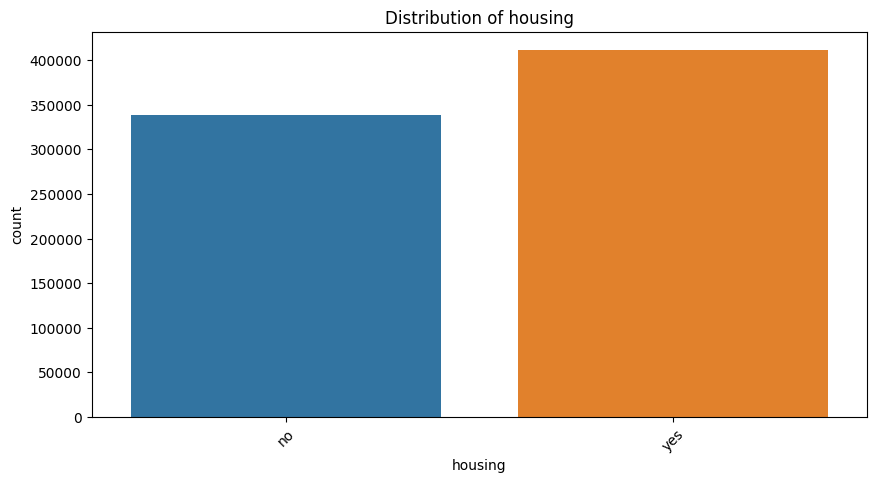

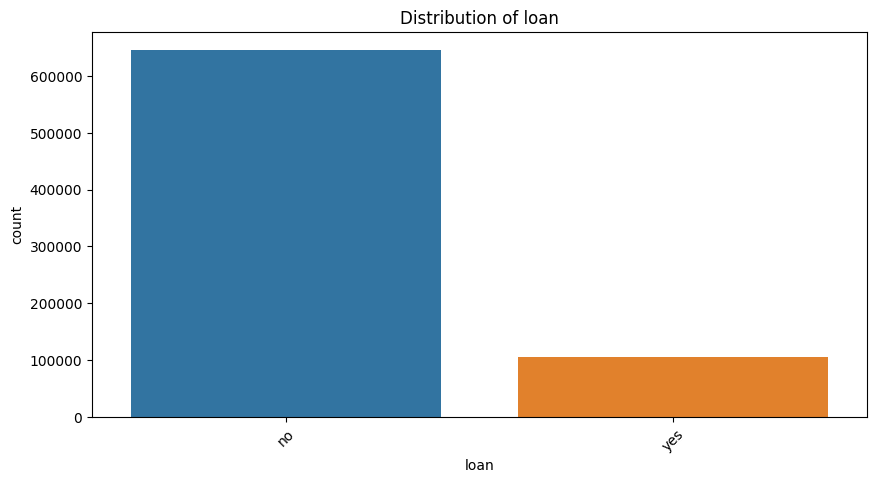

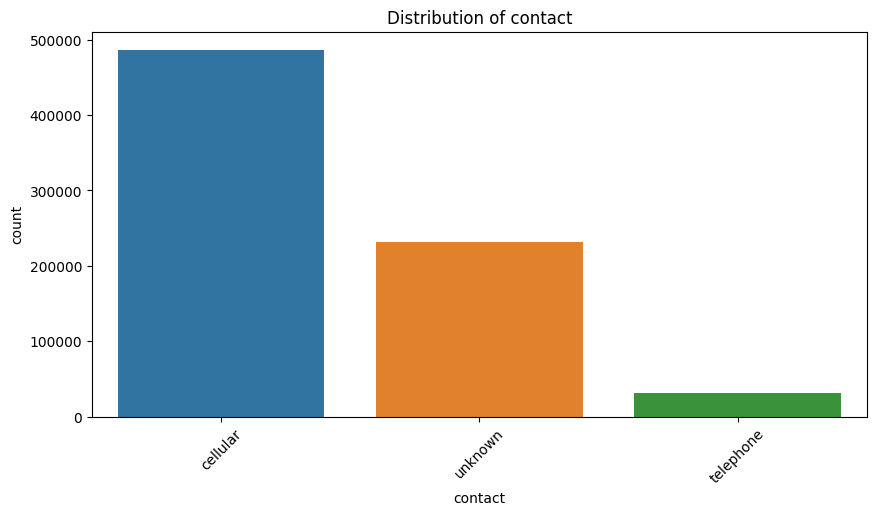

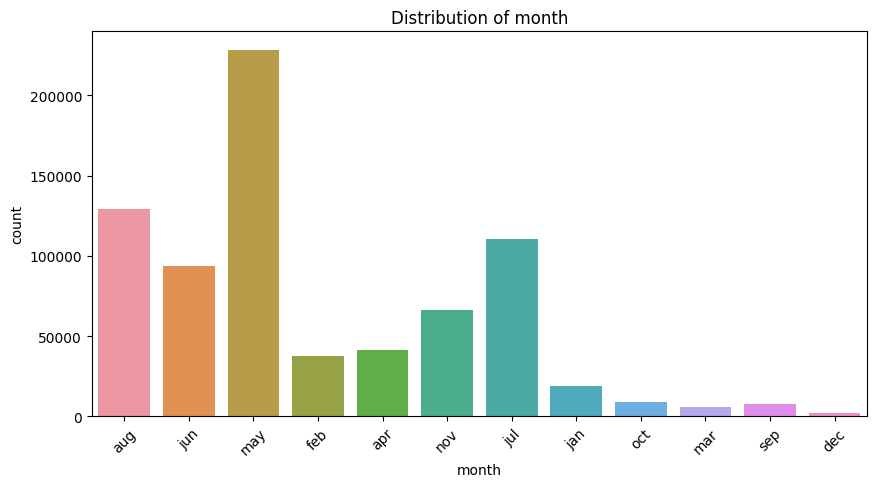

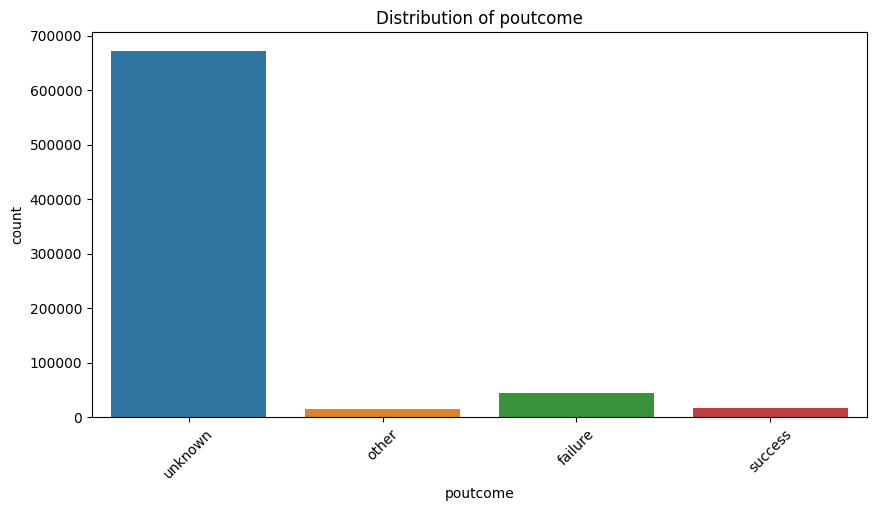

Generating plots for 9 categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


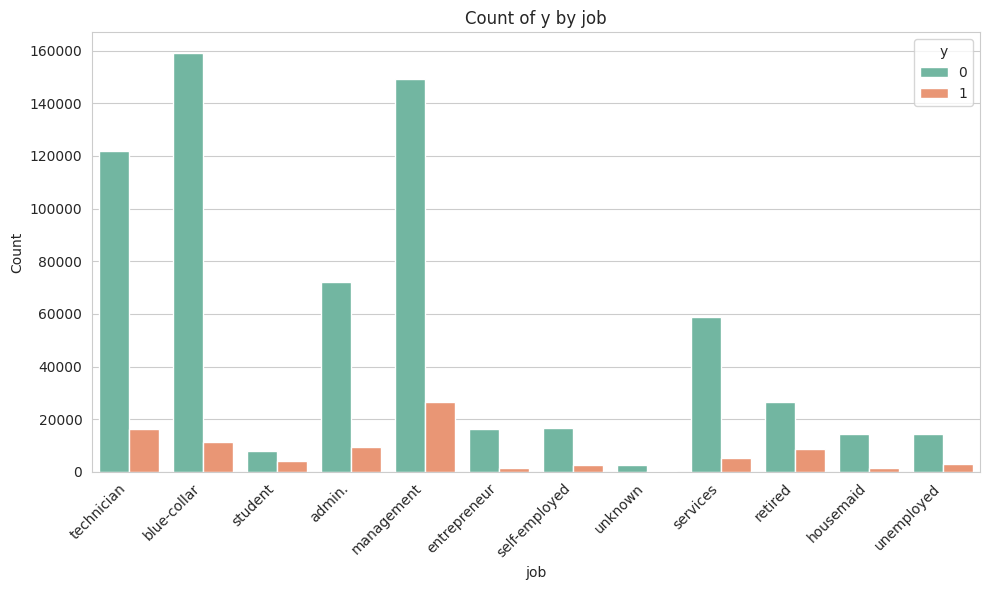

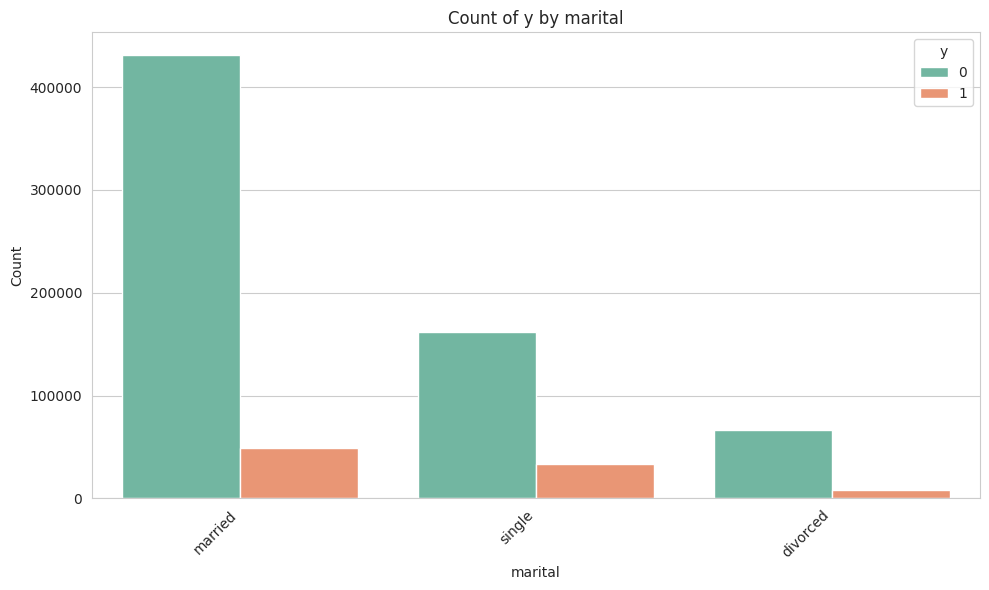

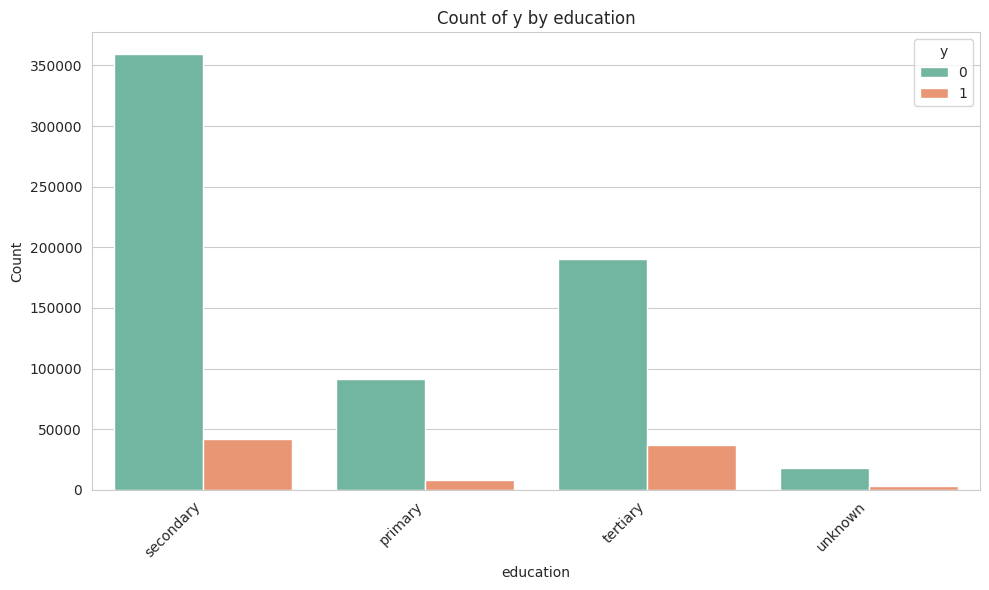

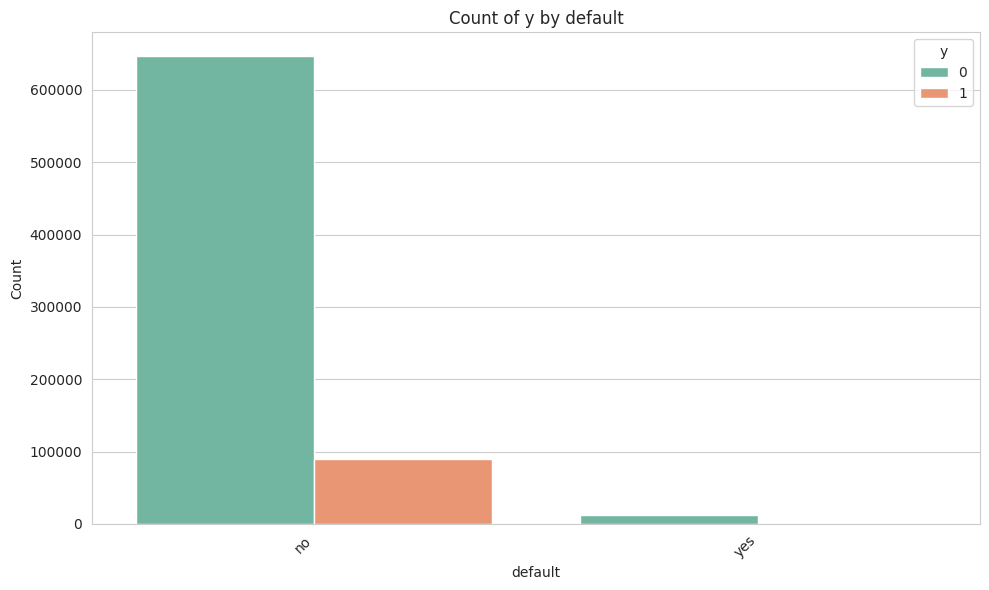

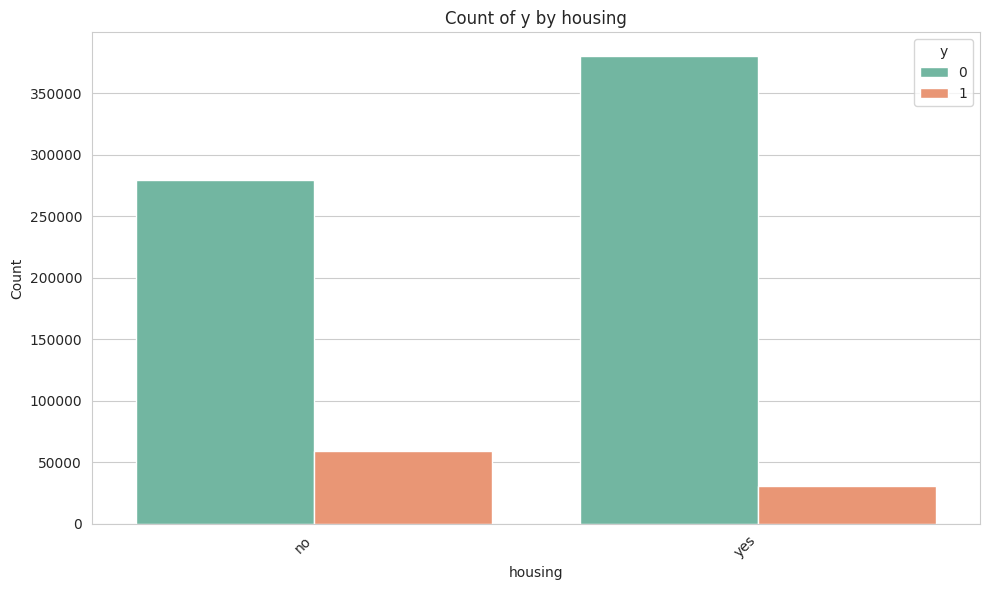

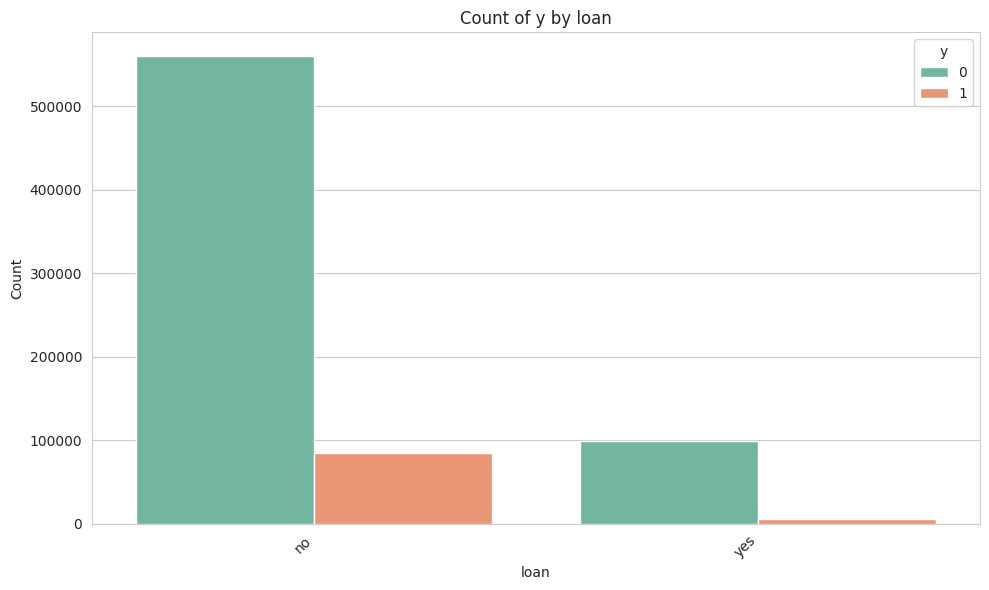

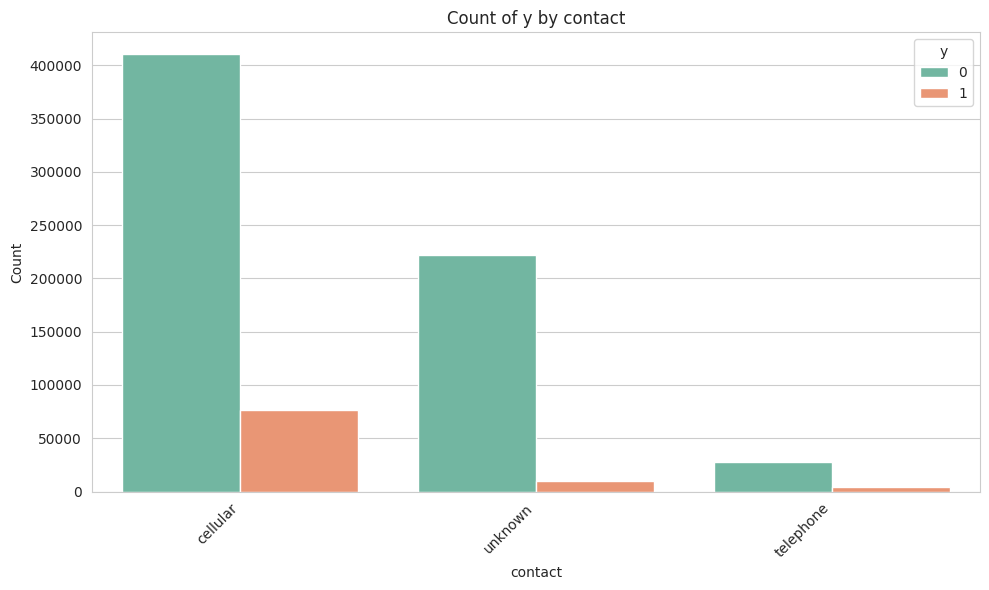

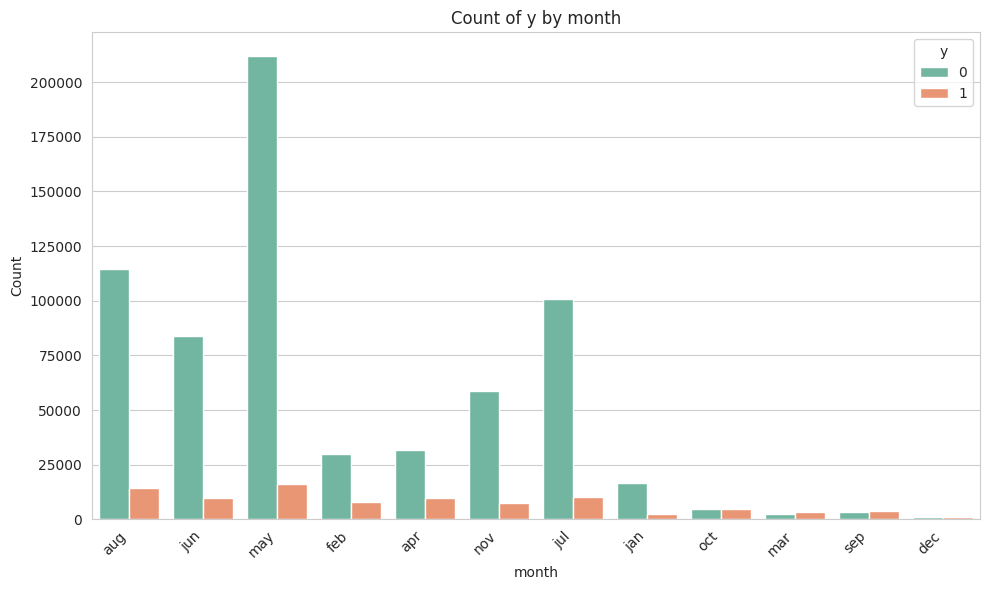

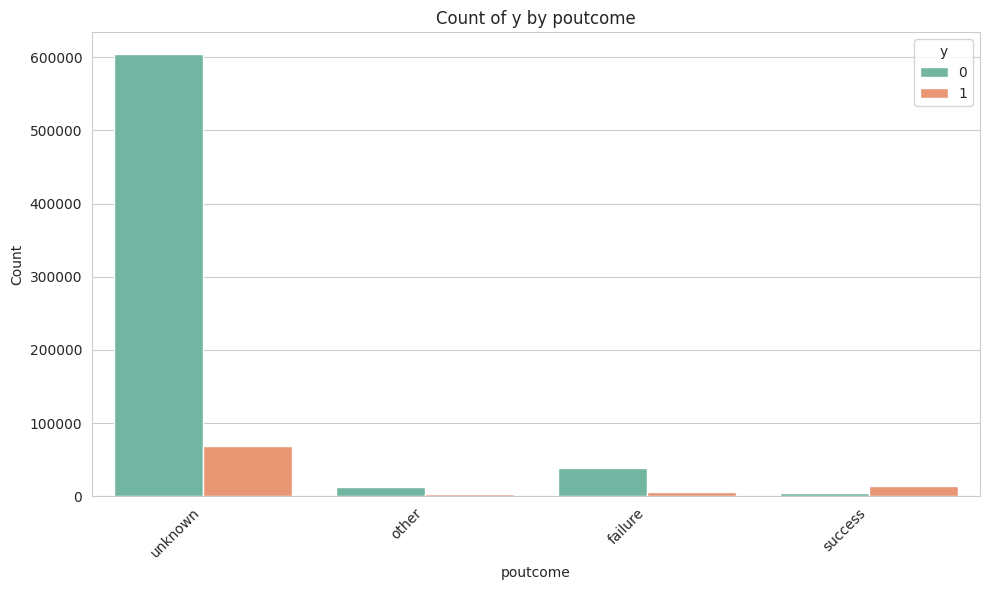

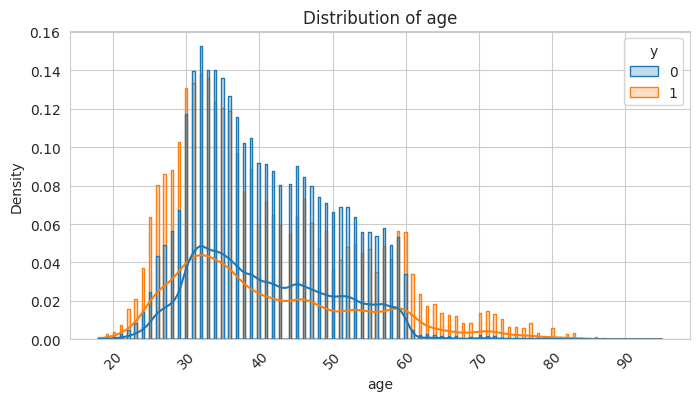

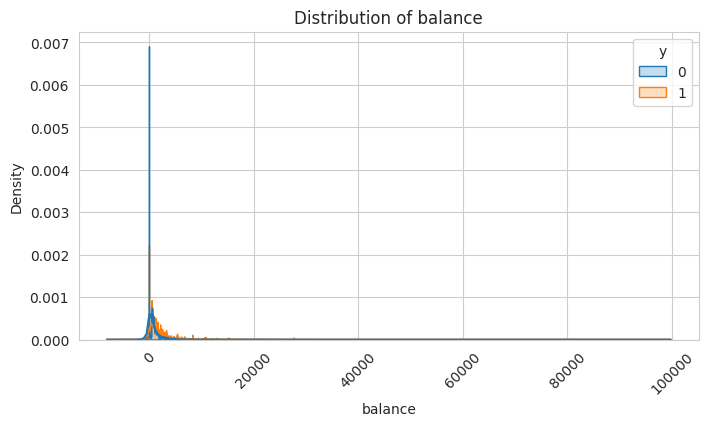

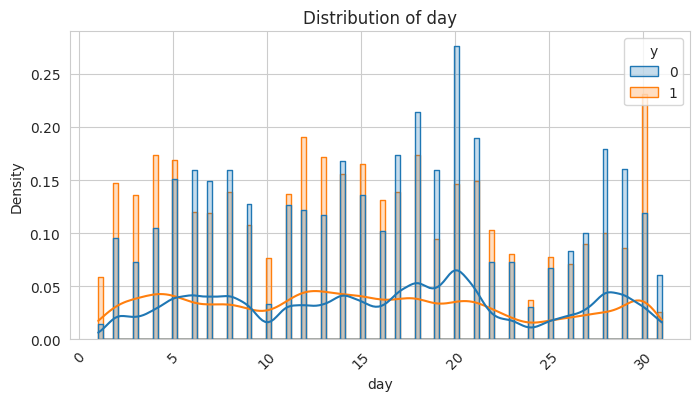

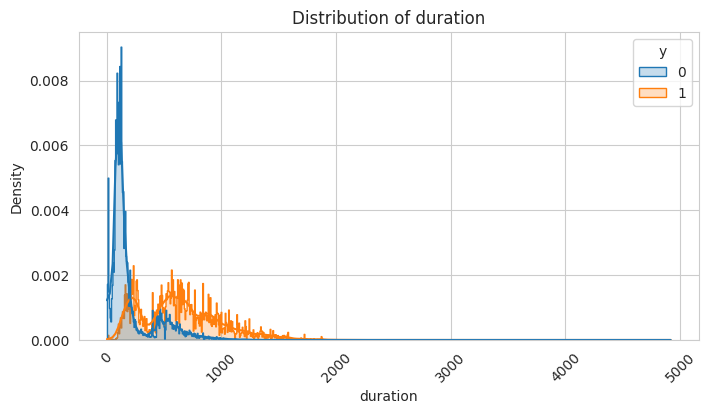

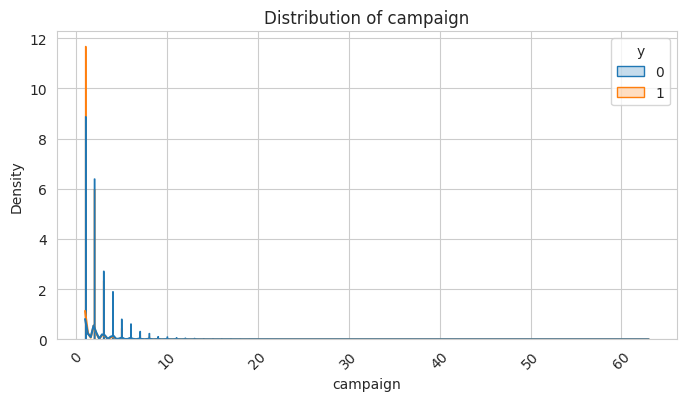

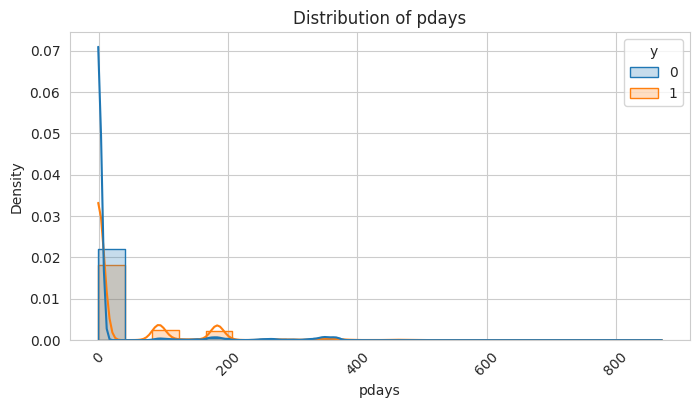

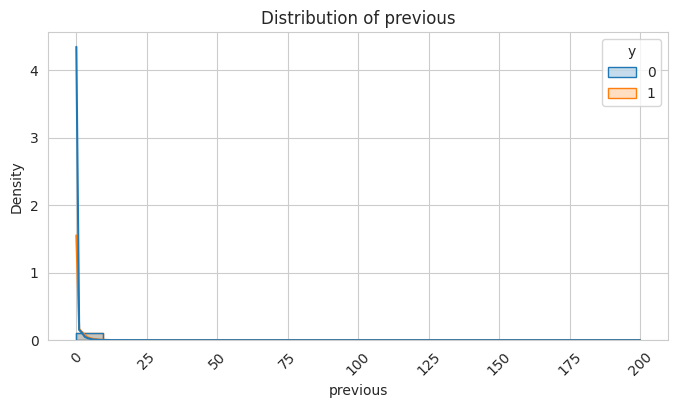

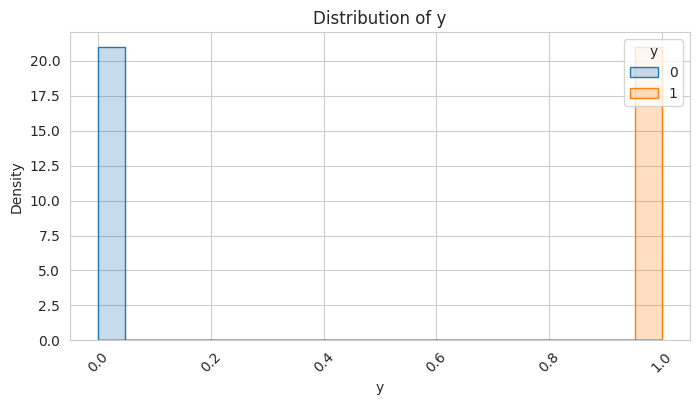

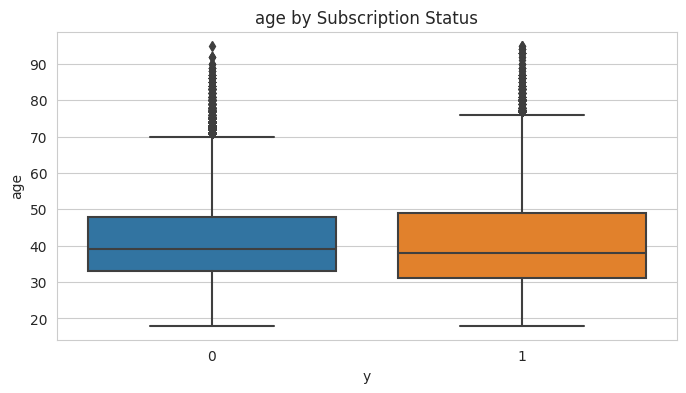

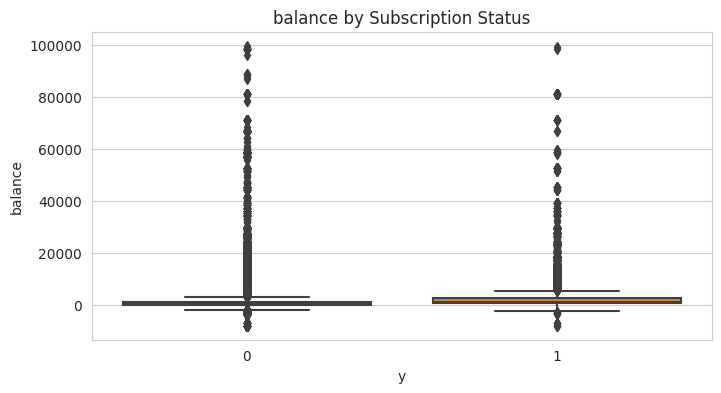

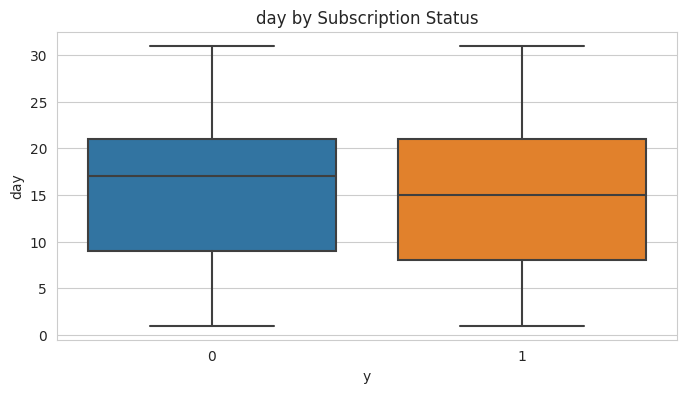

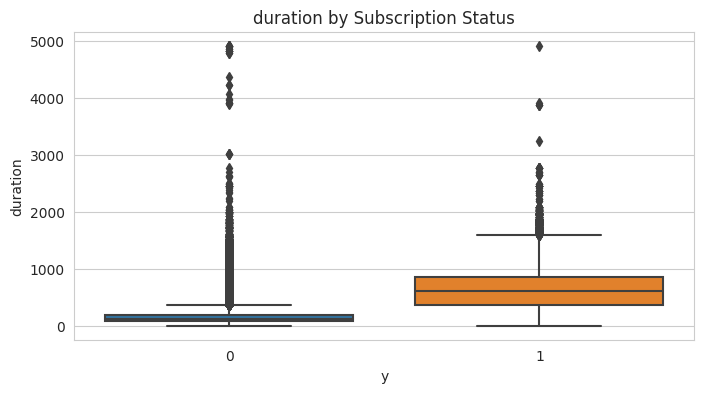

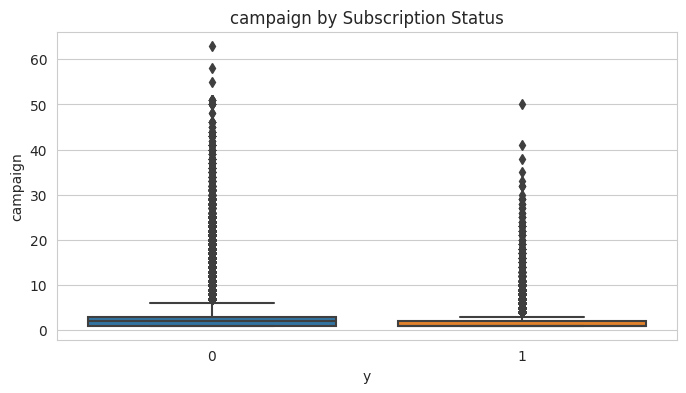

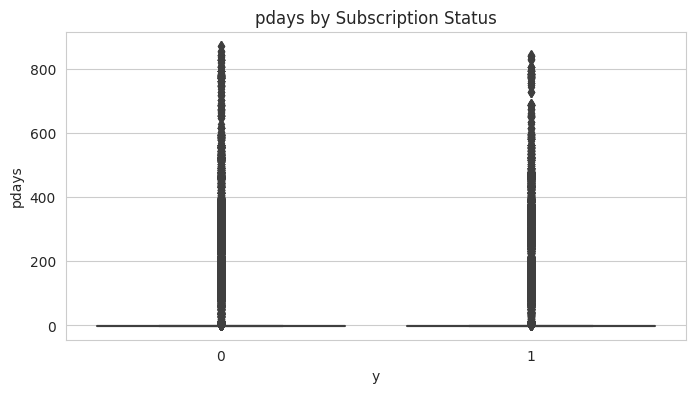

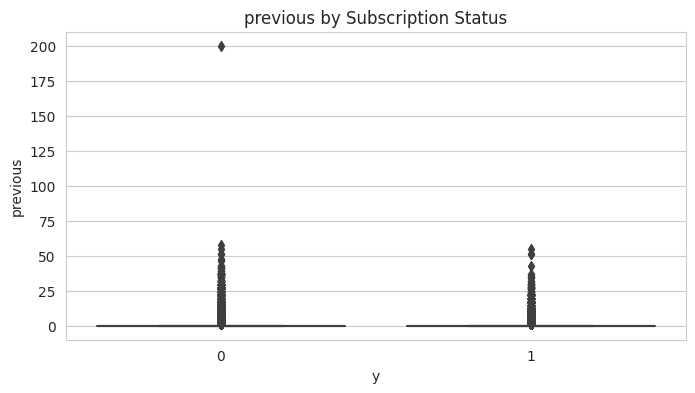

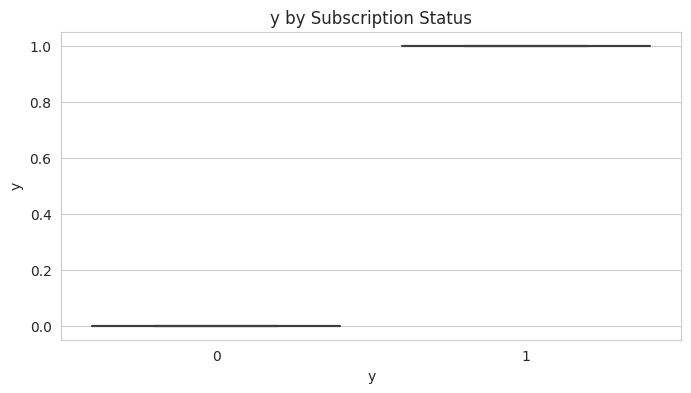

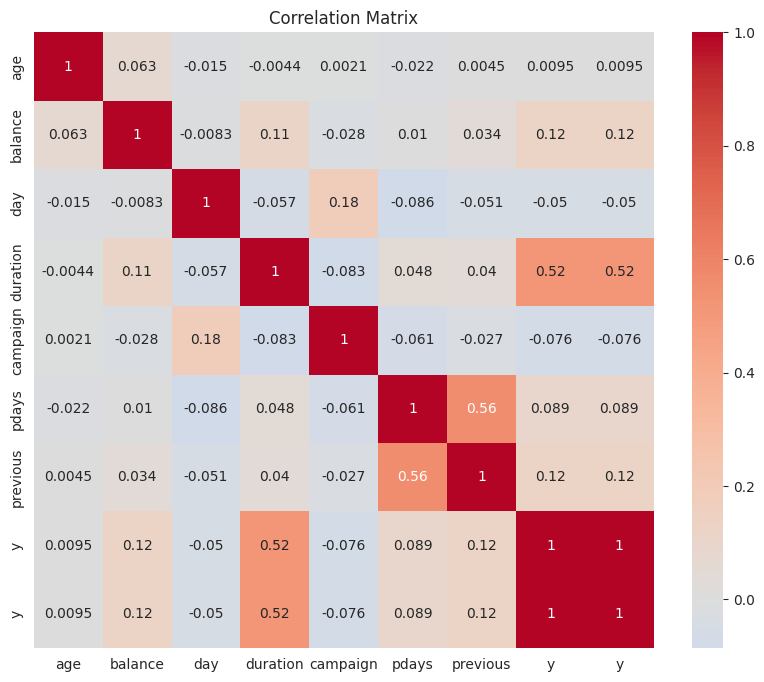

In [19]:
V.all_visual(df_train)


## Looking at the Data with Stats and Charts to Find Patterns and Problems
* For job, management had fewer subscriptions (y=1) than other jobs.
* For marital, single people had a different mix of subscribed (y=1) vs. not subscribed (y=0) compared to others.
* For education, tertiary (3rd) and secondary (2nd) had more subscriptions than other levels.
* For default, people with no default had more subscriptions.
* For loan, people without loans had more subscriptions
* I made histograms for job, marital, education, default, and loan. I saw management jobs had fewer subscriptions than others, single people had a different subscription pattern, tertiary and secondary education had more subscriptions, and people with no default or loan subscribed more. This helped me make features like job_manager and marital_single to capture these patterns.
* I made box plots for continuous features (age, balance, duration, etc.) and saw outliers in all, but there were too many to remove, so I used RobustScaler and binning to handle them without losing data
* I checked describe() on the test data and saw similar outliers, so I kept the same preprocessing to make training and test data consistent.
* I made a heatmap and found duration has a 0.52 correlation with y, meaning longer calls lead to more subscriptions. This made me focus on duration with features like duration_log and duration_favorable.

# **Preprocessing Code**


*  Transforming Raw Data into Model-Ready Features with Binning, Cyclic Encoding, and Pattern-Based Features to Capture Key Patterns for ROC AUC

In [8]:

class preprocessing:
    def __init__(self, df):
        self.df = df.copy()

    def duratio_fetur(self):
        self.df['duration_per_campaign'] = self.df['duration'] / (self.df['campaign'] + 1)
        self.df['duration_squared'] = self.df['duration'] ** 2
        self.df['duration_log'] = np.log1p(self.df['duration'])
        self.df['duration_sqrt'] = np.sqrt(self.df['duration'])
        return self.df

    def contact_category(self):
    
        # Create a column for previous contact category
        self.df['contact_status'] = '0'  # default

        self.df.loc[(self.df['pdays'] != -1) & (self.df['pdays'] <= 30), 'contact_status'] = '1'

        # Old contact
        self.df.loc[(self.df['pdays'] > 30), 'contact_status'] = '2'

        return self.df

    def mont_encoding(self):
        month_map = {
            "jan": 1, "feb": 2, "mar": 3, "apr": 4,
            "may": 5, "jun": 6, "jul": 7, "aug": 8,
            "sep": 9, "oct": 10, "nov": 11, "dec": 12
        }
        self.df["month_num"] = self.df["month"].map(month_map)
        self.df["month_sin"] = np.sin(2 * np.pi * self.df["month_num"] / 12)
        self.df["month_cos"] = np.cos(2 * np.pi * self.df["month_num"] / 12)
        self.df = self.df.drop(columns=['month', 'month_num'])
        return self.df

    def date_encoding(self):
        self.df["day_sin"] = np.sin(2 * np.pi * self.df["day"] / 31)  # Corrected to 31 for days in a month
        self.df["day_cos"] = np.cos(2 * np.pi * self.df["day"] / 31)
        self.df = self.df.drop(columns=['day'])
        return self.df

    def enoding_continus(self):
        self.df['age'] = pd.cut(self.df['age'], bins=[17,37,56,75,95], labels=[0, 1, 2,3]).astype(int)
        self.df['balance'] = pd.cut(self.df['balance'], bins=[-8020,334,887,1600,99718], labels=[0, 1, 2,3]).astype(int)
        self.df['duration'] = pd.cut(self.df['duration'], bins=[-1,102,180,319,645,4918], labels=[0, 1, 2,3,4]).astype(int)
        self.df['campaign'] = pd.cut(self.df['campaign'], bins=[0,3,23,46,63], labels=[0, 1, 2,3]).astype(int)
        self.df['pdays'] = pd.cut(self.df['pdays'], bins=[-2,0,150,380,872], labels=[0, 1, 2,3], right=True, include_lowest=True).astype(int)
        self.df['previous'] = pd.cut(self.df['previous'], bins=[-1,13,26,58,200], labels=[0, 1, 2,3], right=True, include_lowest=True).astype(int)
        return self.df

    def Roscaling(self):
        # initialize scaler
        scaler = RobustScaler()
        cont_columns = ['pdays','previous','campaign','duration','balance','age','duration_per_campaign','duration_log','duration_squared','duration_sqrt']  # Fixed 'duration_sqr' to 'duration_sqrt'
        for i in cont_columns:
            self.df[i] = scaler.fit_transform(self.df[i].values.reshape(-1,1))
        return self.df

    def encoding_chtagrical(self):
        nominal = ['job','marital','contact','poutcome']
        encoder = OneHotEncoder(sparse_output=False)

        # Fit and transform
        encoded = encoder.fit_transform(self.df[nominal])

        # Convert to DataFrame with correct column names
        encoded_df = pd.DataFrame(encoded,
                                  columns=encoder.get_feature_names_out(nominal),
                                  index=self.df.index)

        # Concatenate with original dataframe (and drop old categorical columns)
        self.df = pd.concat([self.df.drop(columns=nominal), encoded_df], axis=1)
        for col in self.df.select_dtypes(include='object').columns:
            le = LabelEncoder()
            self.df[col] = le.fit_transform(self.df[col])
        return self.df

    def extract_features(self):

        # Balance: Store balance value where 0 < balance < 10
        if 'balance' in self.df.columns:
            self.df['balance_favorable'] = self.df['balance'].where((self.df['balance'] > 0) & (self.df['balance'] < 10), np.nan)

        # Duration: Store duration value where duration > 0.5
        if 'duration' in self.df.columns:
            self.df['duration_favorable'] = self.df['duration'].where(self.df['duration'] > 0.5, np.nan)

        # Pdays: Store pdays value where 50 < pdays < 200
        if 'pdays' in self.df.columns:
            self.df['pdays_favorable'] = self.df['pdays'].where((self.df['pdays'] > 50) & (self.df['pdays'] < 200), np.nan)

        # 2. Cyclical Features
        # Month: Store month_sin or month_cos value where month_sin <-0.75 or >0.75, or -0.75 < month_cos < 0.75
        if all(col in self.df.columns for col in ['month_sin', 'month_cos']):
            # Store month_sin if its condition is True
            month_sin_condition = (self.df['month_sin'] < -0.75) | (self.df['month_sin'] > 0.75)
            self.df['month_sin_favorable'] = self.df['month_sin'].where(month_sin_condition, np.nan)

            # Store month_cos if its condition is True
            month_cos_condition = (self.df['month_cos'] > -0.75) & (self.df['month_cos'] < 0.75)
            self.df['month_cos_favorable'] = self.df['month_cos'].where(month_cos_condition, np.nan)

        # Day: Store day_sin or day_cos value where day_sin > 0.25 or day_cos < -0.75 or day_cos > 0.25
        if all(col in self.df.columns for col in ['day_sin', 'day_cos']):
            # Store day_sin if its condition is True
            day_sin_condition = (self.df['day_sin'] > 0.25)
            self.df['day_sin_favorable'] = self.df['day_sin'].where(day_sin_condition, np.nan)

            # Store day_cos if its condition is True
            day_cos_condition = (self.df['day_cos'] < -0.75) | (self.df['day_cos'] > 0.25)
            self.df['day_cos_favorable'] = self.df['day_cos'].where(day_cos_condition, np.nan)

        # Contact: Store contact_cellular value where contact_cellular > 0.9 or contact_unknown < 0.1
        if all(col in self.df.columns for col in ['contact_cellular', 'contact_unknown']):
            contact_condition = (self.df['contact_cellular'] > 0.9) | (self.df['contact_unknown'] < 0.1)
            # Store contact_cellular value if either condition is True
            self.df['contact_favorable'] = self.df['contact_cellular'].where(contact_condition, np.nan)
        # 5. Feature Interactions
        # Store duration value where duration > 0.5 or (contact_cellular > 0.9 or contact_unknown < 0.1)
        if all(col in self.df.columns for col in ['duration', 'contact_cellular', 'contact_unknown']):
            interaction_condition = (self.df['duration'] > 0.5) | (self.df['contact_cellular'] > 0.9) | \
                                   (self.df['contact_unknown'] < 0.1)
            self.df['duration_contact_interaction'] = self.df['duration'].where(interaction_condition, np.nan)
        self.df.fillna(0, inplace=True)

        return self.df

    def combination(self):
        combinations = [
            ('poutcome_success', 'duration_favorable', 'pdays_favorable'),
        ]

        # Loop through and create new columns
        for combo in combinations:
            col_name = "_".join(combo)  # name like 'duration_pdays_poutcome_success'
            self.df[col_name] = self.df[list(combo)].max(axis=1)

        # Now new_df contains only the combined columns
        print(self.df.head())
        return self.df

    def all_prprocesing(self):
        self.duratio_fetur()
        self.contact_category()
        self.mont_encoding()
        self.date_encoding()
        self.enoding_continus()
        self.Roscaling()
        self.encoding_chtagrical()
        self.extract_features()
        self.combination()
        return self.df

In [9]:
Tr=preprocessing(df_train)
process_df_train=Tr.all_prprocesing()

   age  education  default  balance  housing  loan  duration  campaign  pdays  \
0  0.0          1        0     -0.5        0     0  0.000000       0.0    0.0   
1  0.0          1        0      0.0        0     0  0.333333       0.0    0.0   
2 -1.0          1        0      0.0        1     0  0.000000       0.0    0.0   
3 -1.0          1        0     -0.5        1     0 -0.333333       0.0    0.0   
4 -1.0          1        0      0.5        1     0  1.000000       0.0    0.0   

   previous  ...  balance_favorable  duration_favorable  pdays_favorable  \
0       0.0  ...                0.0                 0.0              0.0   
1       0.0  ...                0.0                 0.0              0.0   
2       0.0  ...                0.0                 0.0              0.0   
3       0.0  ...                0.0                 0.0              0.0   
4       0.0  ...                0.5                 1.0              0.0   

   month_sin_favorable  month_cos_favorable  day_sin_fav

* ## **Data with Binning, Encoding, and New Features to Boost Model Accuracy for Subscriptions:**
    * **I created a Preprocessing class to make features like duration_log, duration_sqrt, and duration_per_campaign (duration divided by contacts) because my heatmap showed duration is key, and these transformations capture non-linear patterns better.**
    * **I turned month and day into cyclic features (month_sin, month_cos, day_sin, day_cos) because months and days repeat, and this encoding helps the model see these patterns, improving accuracy.**
    * **I binned numerical features like age (17–37, 37–56, etc.), balance, and duration (0–102, 102–180, etc.) into groups based on my histograms, where certain ranges (e.g., duration 319–645) had more subscriptions. Binning simplifies patterns and handles outliers.**
    * **I made contact_status from pdays (e.g., 0 for no contact, 1 for 0–50 days) because my histograms showed pdays between 50–200 had more subscriptions, helping the model focus on these customers.**
    * **I used RobustScaler on continuous features like duration_per_campaign because my box plots showed outliers, and RobustScaler is better than standard scaling for handling them.**
    * **I used LabelEncoder for categorical columns like job, marital, and education for LightGBM because it’s efficient and improves model accuracy compared to one-hot encoding, which makes too many columns. For other models, I used OneHotEncoder for nominal columns like job but LabelEncoder for ordinal ones like education.**
    * **I added binary features like duration_favorable (is duration in 319–645 range?) and pdays_favorable (is pdays in 50–200 range?) because my histograms showed these ranges had more y=1, helping the model capture subscription patterns.**
    * **I combined poutcome_success, duration_favorable, and pdays_favorable into a new feature (poutcome_duration_pdays) because these features had high impact in my visualizations, and combining them boosts model accuracy by highlighting strong subscription signals.**

# **Testing Different Models**

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

class ImbalanceModelTrainer:
    def __init__(self, X, y, test_size=0.2, random_state=42):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.models = {}
        self.results = {}
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

    def train_models(self):
        # Logistic Regression with class_weight
        self.models["LogisticRegression"] = LogisticRegression(
            class_weight="balanced", solver="liblinear", random_state=self.random_state
        )

        # Random Forest with class_weight
        self.models["RandomForest"] = RandomForestClassifier(
            n_estimators=200, class_weight="balanced",
            random_state=self.random_state, n_jobs=-1
        )

        # LightGBM with class_weight
        self.models["LightGBM"] = LGBMClassifier(
            n_estimators=300, class_weight="balanced",
            random_state=self.random_state, n_jobs=-1
        )

        # XGBoost with GPU support + scale_pos_weight
        scale_pos_weight = np.sum(self.y_train == 0) / np.sum(self.y_train == 1)
        self.models["XGBoost"] = XGBClassifier(
            n_estimators=300,
            objective="binary:logistic",
            tree_method="gpu_hist",  # GPU acceleration
            predictor="gpu_predictor",
            scale_pos_weight=scale_pos_weight,
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric="logloss"
        )

        # Train all models
        for name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            preds = model.predict_proba(self.X_test)[:, 1]
            roc_score = roc_auc_score(self.y_test, preds)
            self.results[name] = roc_score
            y_pred = model.predict(self.X_test)
            score = f1_score(self.y_test, y_pred, average="binary")
            print(f"✅ {name} F1-score: {score:.4f}")
            print(classification_report(self.y_test, y_pred))

    def get_best_model(self):
        best_model = max(self.results, key=self.results.get)
        return best_model, self.results[best_model]

    def summary(self):
        return pd.DataFrame.from_dict(self.results, orient="index", columns=["ROC_AUC"]).sort_values(by="ROC_AUC", ascending=False)



In [11]:
X=process_df_train.drop(['y'],axis=1)
y=process_df_train['y']

In [28]:
trainer = ImbalanceModelTrainer(X, y)
trainer.train_models()
print(trainer.summary())
print("Best Model:", trainer.get_best_model())


✅ LogisticRegression F1-score: 0.6051
              precision    recall  f1-score   support

           0       0.98      0.85      0.91    131902
           1       0.45      0.90      0.61     18098

    accuracy                           0.86    150000
   macro avg       0.72      0.88      0.76    150000
weighted avg       0.92      0.86      0.88    150000

✅ RandomForest F1-score: 0.6835
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    131902
           1       0.75      0.63      0.68     18098

    accuracy                           0.93    150000
   macro avg       0.85      0.80      0.82    150000
weighted avg       0.93      0.93      0.93    150000

✅ LightGBM F1-score: 0.6600
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    131902
           1       0.51      0.94      0.66     18098

    accuracy                           0.88    150000
   macro avg       0.75      0

* **I made an ImbalanceModelTrainer class to test Logistic Regression, Random Forest, LightGBM, and XGBoost, using stratified splits to keep the 12% y=1 ratio. I used class_weight='balanced' or scale_pos_weight because my describe() showed imbalance, and these settings help models focus on y=1**
* **I checked ROC AUC scores and found LightGBM was best because it handles my engineered features (like duration_favorable) and imbalanced data well, capturing more subscriptions than others, which struggled even with balancing.**

In [67]:
import optuna
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import time

def run_xgboost_optuna(X,y, time_limit=3200):
    """
    Runs XGBoost with Optuna hyperparameter tuning.
    Stops automatically after `time_limit` seconds.
    Returns best model and score.
    """
    
    X_train,  X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
            "random_state": 42,
            "tree_method": "gpu_hist",  # GPU acceleration
            "use_label_encoder": False,
            "eval_metric": "logloss"
        }
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, preds)
        return score

    # Define study with time limit
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, timeout=time_limit)

    print("✅ Best ROC AUC:", study.best_value)
    print("✅ Best Params:", study.best_params)

    # Train final model on full data with best params
    best_model = XGBClassifier(**study.best_params,
                               random_state=42,
                               tree_method="gpu_hist",
                               use_label_encoder=False,
                               eval_metric="logloss")
    best_model.fit(X_train, y_train)

    return best_model, study.best_value, study.best_params


In [68]:
model, best_score, best_params = run_xgboost_optuna(
    X,y
)

[I 2025-08-29 16:50:05,763] A new study created in memory with name: no-name-7a8afef3-a007-4dbb-a60f-29a13f88792d
[I 2025-08-29 16:50:10,221] Trial 0 finished with value: 0.9582866673977215 and parameters: {'n_estimators': 459, 'max_depth': 5, 'learning_rate': 0.013848888867379436, 'subsample': 0.6460254908245671, 'colsample_bytree': 0.5105888937012832, 'gamma': 3.5751007712127003, 'reg_alpha': 4.421103293972475, 'reg_lambda': 6.673487119477176, 'scale_pos_weight': 4.445227102225207}. Best is trial 0 with value: 0.9582866673977215.
[I 2025-08-29 16:50:12,295] Trial 1 finished with value: 0.9566797178636521 and parameters: {'n_estimators': 135, 'max_depth': 3, 'learning_rate': 0.10253399296481812, 'subsample': 0.8431538799878727, 'colsample_bytree': 0.6728272604655681, 'gamma': 4.614267641446872, 'reg_alpha': 7.572618001035493, 'reg_lambda': 4.58815424769894, 'scale_pos_weight': 8.443489539288354}. Best is trial 0 with value: 0.9582866673977215.
[I 2025-08-29 16:50:15,970] Trial 2 finis

✅ Best ROC AUC: 0.9665191559091565
✅ Best Params: {'n_estimators': 931, 'max_depth': 10, 'learning_rate': 0.04218014758007532, 'subsample': 0.934071443352955, 'colsample_bytree': 0.7518299151933546, 'gamma': 0.6450655123455616, 'reg_alpha': 6.908445628217499, 'reg_lambda': 7.148560631935883, 'scale_pos_weight': 1.4957405831278414}


In [10]:
test_ids = test['id'].copy()  # Save IDs as a Series
test_process = test.drop(columns=['id'])  # DataFrame without 'ID' for processing

# Step 2: Instantiate the preprocessing class and apply all_prprocesing
Ts = preprocessing(test_process)
transformed_test = Ts.all_prprocesing()

# Step 3: Reattach 'ID' to the transformed DataFrame (insert at the beginning for clarity)
#transformed_test.insert(0, 'id', test_ids)



   age  education  default  balance  housing  loan  duration  campaign  pdays  \
0 -1.0          1        0      0.5        1     0  0.333333       0.0    0.0   
1  0.0          2        0     -0.5        1     0  0.666667       0.0    0.0   
2 -1.0          0        0     -0.5        1     1  0.000000       0.0    0.0   
3  1.0          1        0     -0.5        1     1  0.000000       0.0    0.0   
4 -1.0          1        0      1.0        1     0  0.333333       0.0    0.0   

   previous  ...  balance_favorable  duration_favorable  pdays_favorable  \
0       0.0  ...                0.5            0.000000              0.0   
1       0.0  ...                0.0            0.666667              0.0   
2       0.0  ...                0.0            0.000000              0.0   
3       0.0  ...                0.0            0.000000              0.0   
4       0.0  ...                1.0            0.000000              0.0   

   month_sin_favorable  month_cos_favorable  day_sin_fav

# Tuning LightGBM

In [11]:
import optuna
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def run_lightgbm_optuna(X, y, time_limit=3200):
    """
    Runs LightGBM with Optuna hyperparameter tuning.
    Stops automatically after `time_limit` seconds.
    Returns best model and score.
    """

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 500, 5000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 256),
            "max_depth": trial.suggest_int("max_depth", -1, 12),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
            "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
            "objective": "binary",
            "metric": "auc",
            "random_state": 42,
            "n_jobs": -1,
            "device": "gpu"
        }
        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_valid)[:, 1]
        score = roc_auc_score(y_valid, preds)
        return score

    # Define study with time limit
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, timeout=time_limit)

    print("✅ Best ROC AUC:", study.best_value)
    print("✅ Best Params:", study.best_params)

    # Train final model on full training data with best params
    best_model = LGBMClassifier(**study.best_params, n_jobs=-1)
    best_model.fit(X_train, y_train)

    return best_model, study.best_value, study.best_params



In [10]:
Tr=preprocessing(df_train)
process_tain=Tr.all_prprocesing()

   age  education  default  balance  housing  loan  duration  campaign  pdays  \
0  0.0          1        0     -0.5        0     0  0.000000       0.0    0.0   
1  0.0          1        0      0.0        0     0  0.333333       0.0    0.0   
2 -1.0          1        0      0.0        1     0  0.000000       0.0    0.0   
3 -1.0          1        0     -0.5        1     0 -0.333333       0.0    0.0   
4 -1.0          1        0      0.5        1     0  1.000000       0.0    0.0   

   previous  ...  balance_favorable  duration_favorable  pdays_favorable  \
0       0.0  ...                0.0                 0.0              0.0   
1       0.0  ...                0.0                 0.0              0.0   
2       0.0  ...                0.0                 0.0              0.0   
3       0.0  ...                0.0                 0.0              0.0   
4       0.0  ...                0.5                 1.0              0.0   

   month_sin_favorable  month_cos_favorable  day_sin_fav

In [12]:
X=process_tain.drop(['y'],axis=1)
y=process_tain['y']

In [ ]:
best_params

In [ ]:
best_model, best_value, best_params=run_lightgbm_optuna(X,y)

[I 2025-08-30 15:50:22,774] A new study created in memory with name: no-name-cdbd0053-a174-41a8-8a8b-b5a64671b93d


[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 50
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (11.44 MB) transferred to GPU in 0.021071 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-08-30 15:52:56,568] Trial 0 finished with value: 0.9657553080020954 and parameters: {'n_estimators': 2646, 'learning_rate': 0.02143958429998394, 'num_leaves': 246, 'max_depth': 11, 'subsample': 0.8191667685185682, 'colsample_bytree': 0.7942546931322698, 'min_child_samples': 57, 'reg_alpha': 1.7790234562116432, 'reg_lambda': 0.3398918606179674, 'scale_pos_weight': 4.71417563899984, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.9657553080020954.


[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 50
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (11.44 MB) transferred to GPU in 0.020148 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289


[I 2025-08-30 16:02:23,513] Trial 1 finished with value: 0.9663073613530564 and parameters: {'n_estimators': 649, 'learning_rate': 0.09332677557423488, 'num_leaves': 222, 'max_depth': 0, 'subsample': 0.9096193263422974, 'colsample_bytree': 0.647379276763177, 'min_child_samples': 81, 'reg_alpha': 3.376984953579881, 'reg_lambda': 0.01979410067101839, 'scale_pos_weight': 5.663171720691174, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.9663073613530564.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 50
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (11.44 MB) transferred to GPU in 0.020069 secs. 

[I 2025-08-30 16:08:58,747] Trial 2 finished with value: 0.9641322822680725 and parameters: {'n_estimators': 4983, 'learning_rate': 0.03160805615017457, 'num_leaves': 129, 'max_depth': 12, 'subsample': 0.8327173413675342, 'colsample_bytree': 0.8070333394258522, 'min_child_samples': 59, 'reg_alpha': 1.6810888295809772, 'reg_lambda': 3.34421591792956, 'scale_pos_weight': 7.247250873053871, 'boosting_type': 'goss'}. Best is trial 1 with value: 0.9663073613530564.


[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 50
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (11.44 MB) transferred to GPU in 0.020747 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289


[I 2025-08-30 16:10:14,404] Trial 3 finished with value: 0.9654052249908179 and parameters: {'n_estimators': 1824, 'learning_rate': 0.06244456473456975, 'num_leaves': 139, 'max_depth': -1, 'subsample': 0.7080801723190688, 'colsample_bytree': 0.5767661144675806, 'min_child_samples': 36, 'reg_alpha': 1.0969392200011434, 'reg_lambda': 2.0216806776682352, 'scale_pos_weight': 4.871265675744881, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.9663073613530564.


[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1233
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 50
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (11.44 MB) transferred to GPU in 0.020017 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120650 -> initscore=-1.986289
[LightGBM] [Info] Start training from score -1.986289


In [ ]:
best_estimator,best_params=bayesian_opt_lgbm(X, y)

* **I used Bayesian optimization (BayesSearchCV) with 5-fold cross-validation to tune LightGBM parameters like learning_rate=0.01078, num_leaves=379, and max_depth=15 because default settings weren’t good enough, and tuning maximizes ROC AUC while avoiding overfitting. Bayesian optimization is faster than trying every combination.**

# Training LightGBM

In [27]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import numpy as np

def train_lightgbm(train, test, target,best_parms):
    X = train
    y = target
    
    X_test = test.copy()
    
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    y_probs = np.zeros(len(X_test))
    models = []
    
    # Corrected params: 'class_weight' (not 'weights'), remove invalid 'eval_metric'/'metric'
    best_parms = {'n_estimators': 7070,
         'max_depth': 4,
         'learning_rate': 0.030244365338376714,
         'num_leaves': 123,
         'subsample': 0.5482862911705977,
         'colsample_bytree': 0.9844161378445689,
         'min_child_samples': 53,
         'reg_alpha': 6.2614081288266865,
         'reg_lambda': 2.1828761459658073,
         'scale_pos_weight': 1.0904905133935505,
         'random_state': 35}
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\n<== Training fold {fold + 1}/{n_splits} ==>")
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(
            **best_parms,
            
            #random_state=42,
            objective= 'binary',
            metric= 'auc',
            boosting_type= 'gbdt',
            class_weight= 'balanced',   # handles imbalance
            
            n_jobs=-1,
            verbosity=0  # Optional: Reduces logging verbosity (set to -1 for even quieter)
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',  # Moved here for proper AUC evaluation
            callbacks=[
                lgb.early_stopping(500),
                lgb.log_evaluation(300)
            ]
        )
        
        models.append(model)
        y_probs += model.predict_proba(X_test)[:, 1] / n_splits
    
    print("\nLightGBM model training complete.")
    return y_probs, models

In [ ]:
y_probs, models = train_lightgbm(X, transformed_test, y,best_params)


<== Training fold 1/5 ==>
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 500 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7e0af3557ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7e0af3557ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
test_df = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
submission = pd.DataFrame({
    'id': sub_df['id'],
    'target': y_probs 
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")